# Semantic Duplicate Detection: Quora Question Pairs Analysis using Machine Learning



## Introduction and Data Quality
This notebook presents a machine learning (ML)-based solution for the Quora Question Pairs problem on Kaggle. This challenge falls under the realm of natural language processing (NLP) and entails determining whether pairs of questions from the Quora platform are duplicates. The primary objective of this notebook is to create binary classification models capable of determining whether two provided questions are semantically similar or constitute duplicates.

### Dataset
The dataset comprises more than 400,000 observations distributed across 6 columns: 'ID', 'QID1', 'QID2', 'Question1', 'Question2', and 'Is_duplicate'. The initial five columns constitute the independent variables, while the 'Is_duplicate' column serves as the dependent variable. This column contains boolean values that indicate whether the given two questions are duplicates of each other or not.

### Contents
- Loading and processing the dataset
- EDA 
- Feature engineering (1)
- EDA of engineered features (1)
- NLP based feature engineering (2)
- EDA of engineered features (2)
- Predctive modelling



### Installing and importing the necessary modules

In [5]:
!pip install distance

In [6]:
!python -m spacy download en

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
!python -m spacy download en_core_web_lg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [8]:
import numpy as np
from tqdm import tqdm
import spacy
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### 1. Loading and processing the dataset

In [27]:
original_df=pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')

In [29]:
# Ranadomly selecting 50k observations, due to computational constraints

np.random.seed(42)
# Number of observations you want to select randomly
num_samples = 50000

# Randomly select indices from the original DataFrame
random_indices = np.random.choice(original_df.index, num_samples, replace=False)

# Create a new DataFrame with the randomly selected observations
df = original_df.loc[random_indices]

In [31]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [32]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


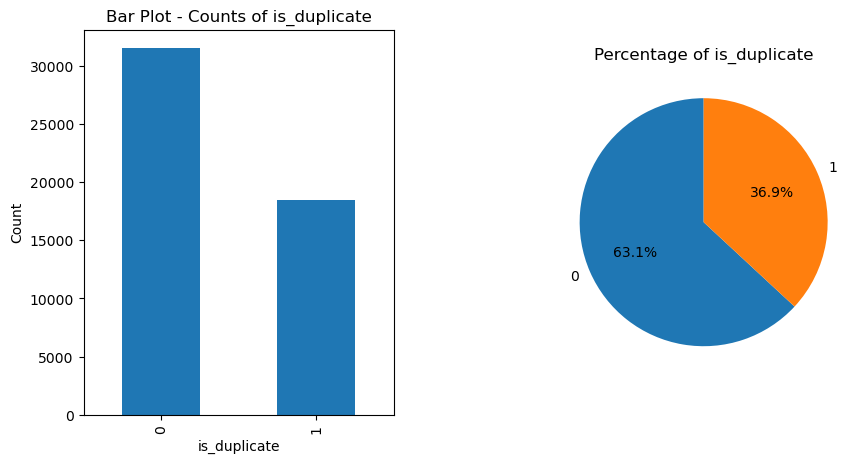

In [33]:
# Group by "is_duplicate" and calculate the count of each group
grouped_counts = df.groupby("is_duplicate")['id'].count()
plt.figure(figsize=(10, 5)) 
# Create a bar plot for the count of records in each group
plt.subplot(1, 2, 1)  # Divide the plot area into 1 row, 2 columns, and select the first plot
grouped_counts.plot(kind='bar')
plt.title('Bar Plot - Counts of is_duplicate')
plt.ylabel('Count')

# Create a pie chart for the percentage distribution
plt.subplot(1, 2, 2)  # Select the second plot
grouped_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Percentage of is_duplicate')
plt.ylabel('')

# Adjust layout to prevent overlapping of plots
plt.subplots_adjust(wspace=0.5)

# Display the plots
plt.show()


Upon examining instances stratified by the output class, it becomes evident that a subtle class imbalance exists. Approximately 63% of the instances are labeled as 'is_duplicate=False,' while the remaining 37% of instances are labeled as 'is_duplicate=True.

In [34]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 


Total number of  Unique Questions are: 89109

Number of unique questions that appear more than one time: 7329 (8.224758441908225%)

Max number of times a single question is repeated: 20



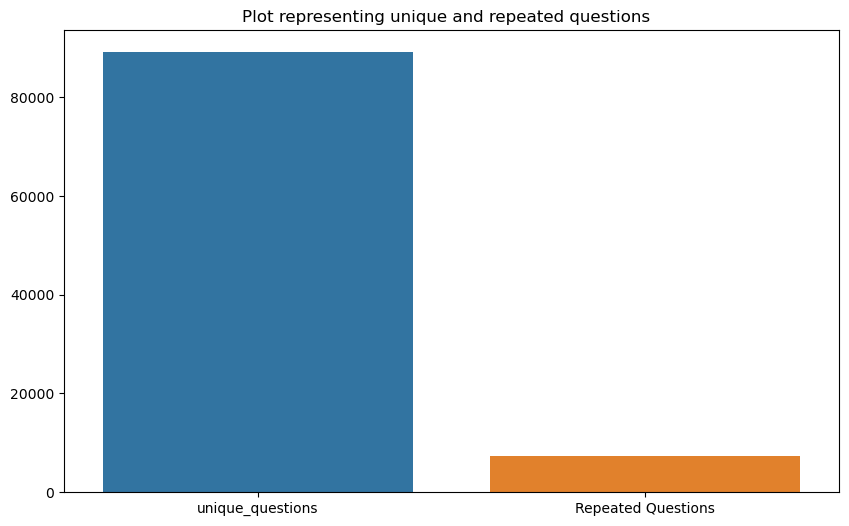

In [35]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x=x,y=y)
plt.show()

In [36]:


#Duplicate count

pairs = df[['qid1', 'qid2']].values.tolist()
pair_count = {}

for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    pair_count[sorted_pair] = pair_count.get(sorted_pair, 0) + 1

duplicate_pairs = {pair: count for pair, count in pair_count.items() if count > 1}

print("Number of duplicate pairs:", len(duplicate_pairs))
print("List of duplicate pairs:", duplicate_pairs)


Number of duplicate pairs: 0
List of duplicate pairs: {}


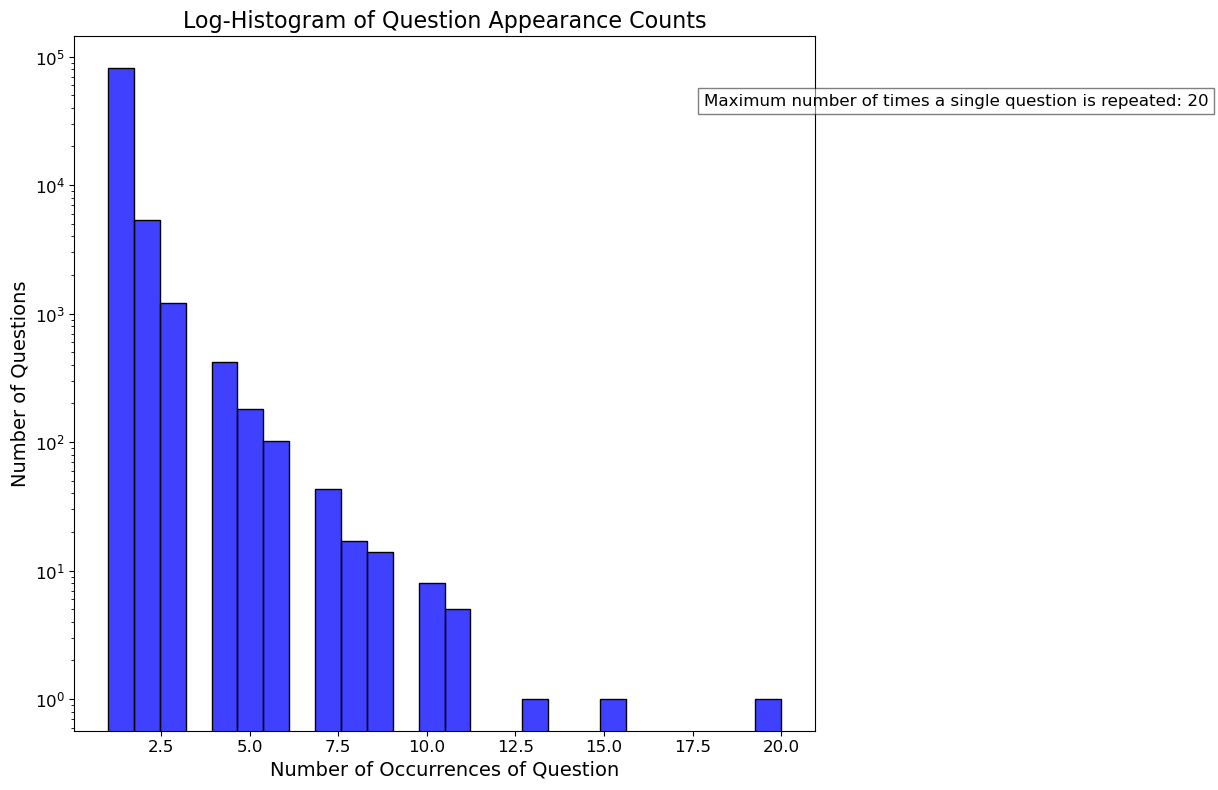

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))  # Adjust the figure size

# Create a histogram
sns.histplot(data=qids.value_counts(), bins=20, kde=False, color='blue')  # Using sns.histplot for better styling

plt.gca().set_yscale('log')  # Set y-axis scale to log

plt.title('Log-Histogram of Question Appearance Counts', fontsize=16)  # Increase title font size

plt.xlabel('Number of Occurrences of Question', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Number of Questions', fontsize=14)  # Increase y-axis label font size

plt.xticks(fontsize=12)  # Increase tick label font size
plt.yticks(fontsize=12)  # Increase tick label font size

# Display the maximum number of times a single question is repeated
max_count = max(qids.value_counts())
plt.text(0.85, 0.9, f'Maximum number of times a single question is repeated: {max_count}',
         fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()  # Improve layout spacing

plt.show()


The histogram plotted on a logarithmic scale, depicting the frequency distribution of question occurrences, reveals an intriguing pattern. A significant portion, approximately 10^5 questions, has appeared only once. Curiously, there exists a solitary question that has been encountered 20 times. Between these two extremes, the frequency demonstrates an exponential decline.

### 2. Feature Engineering (1)

The following features have been introduced to the dataset:

- `freq_qid1`: Frequency of qid1's
- `freq_qid2`: Frequency of qid2's
- `q1len`: Length of q1
- `q2len`: Length of q2
- `q1_n_words`: Number of words in Question 1
- `q2_n_words`: Number of words in Question 2
- `word_Common`: Number of unique words common to both Question 1 and Question 2
- `word_Total`: Total number of words in Question 1 and Question 2 combined
- `word_share`: Proportion of shared words, calculated as `(word_Common) / (word_Total)`
- `freq_q1 + freq_q2`: Sum of the frequencies of qid1 and qid2
- `freq_q1 - freq_q2`: Absolute difference between the frequencies of qid1 and qid2"


In [38]:
#Freq of each question
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

#String length of each question
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

#No of words in each question
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

#Intersection count of words in both question
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(normalized_word_Common, axis=1)

#Union count of words of both the questions
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))

df['word_Total'] = df.apply(normalized_word_Total, axis=1)

#Ratio of unique words to no.of words
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

df['word_share'] = df.apply(normalized_word_share, axis=1)

#Sum and difference of the frequencies of both the questions
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

df.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,1,1,34,34,8,8,7.0,16.0,0.437500,2,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,1,1,53,51,11,9,6.0,20.0,0.300000,2,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,1,1,96,45,16,8,2.0,24.0,0.083333,2,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,2,2,44,52,7,9,4.0,16.0,0.250000,4,0
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,1,4,38,29,9,7,3.0,16.0,0.187500,5,3


### 3. EDA of Engineered features (1)

In [39]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 6
Number of Questions with minimum length [question2] : 5


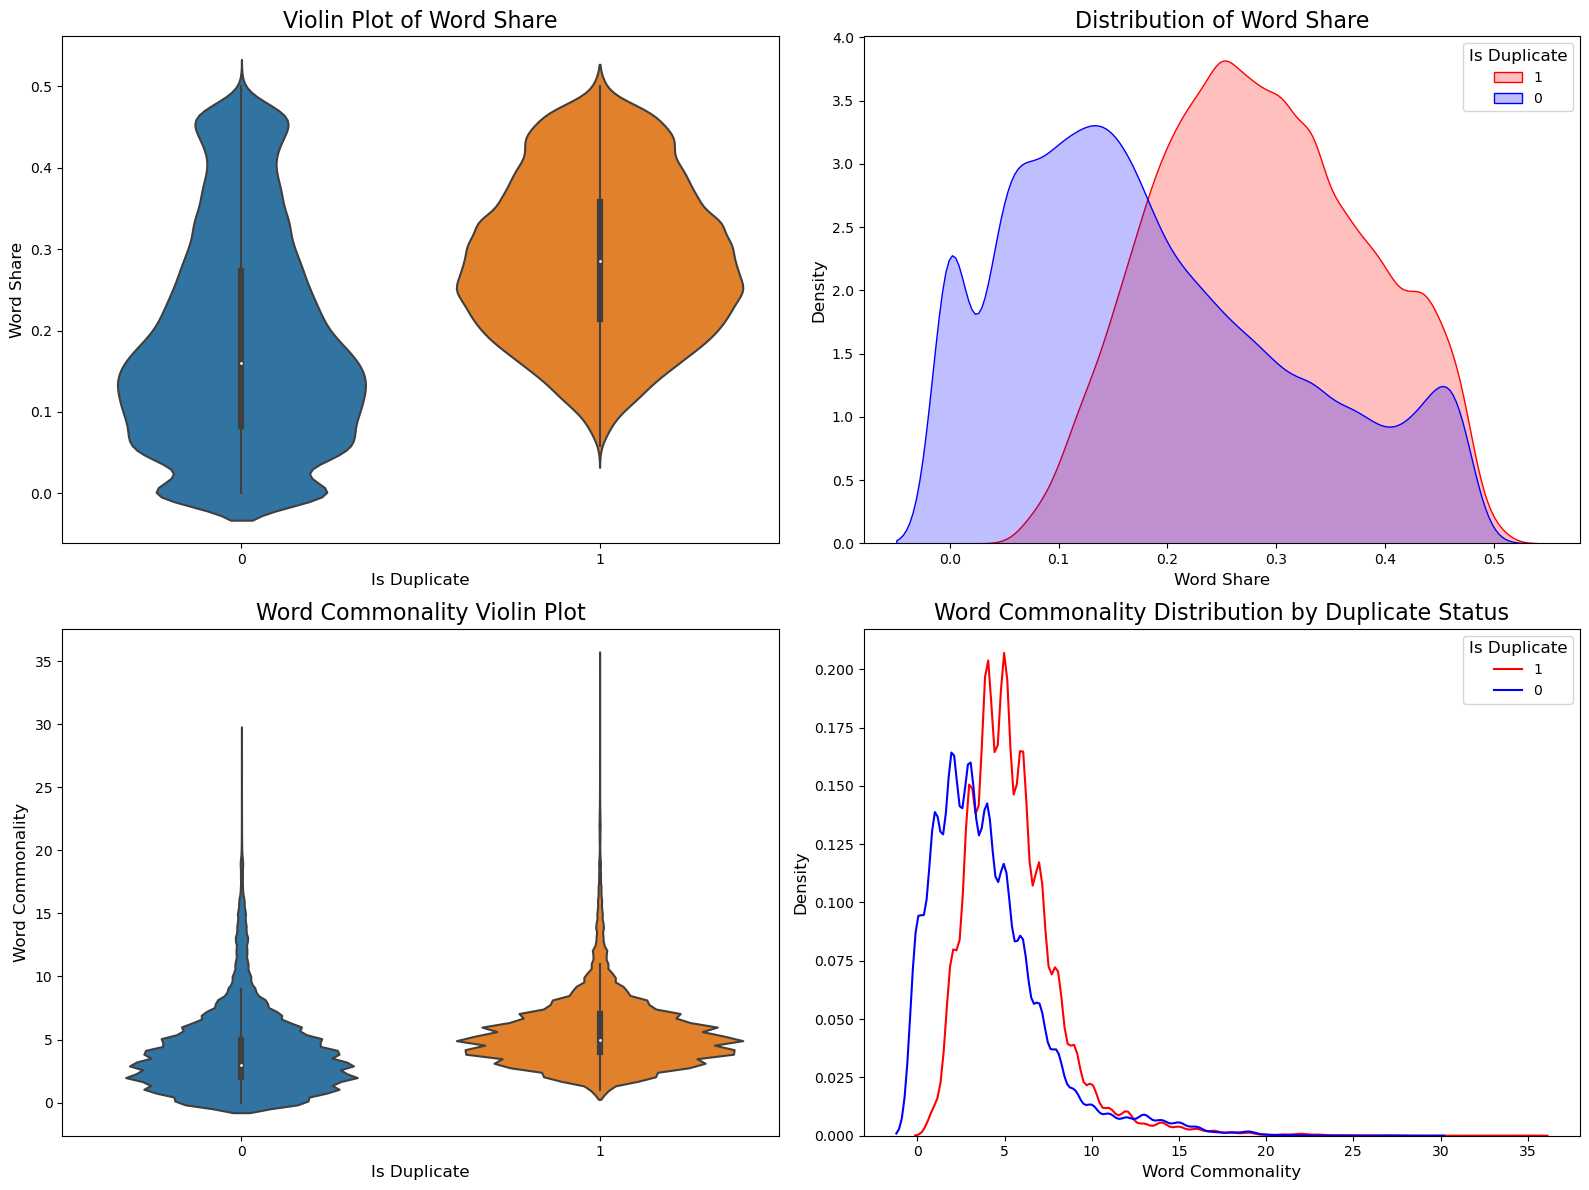

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))  # Increase the overall figure size

# First subplot - Violin plot of Word Share
plt.subplot(2, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=df)
plt.title("Violin Plot of Word Share", fontsize=16)
plt.xlabel("Is Duplicate", fontsize=12)
plt.ylabel("Word Share", fontsize=12)

# Second subplot - Distribution plot of Word Share
plt.subplot(2, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label="1", color='red', hist=False, kde_kws={'shade': True})
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label="0", color='blue', hist=False, kde_kws={'shade': True})
plt.title("Distribution of Word Share", fontsize=16)
plt.xlabel("Word Share", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Is Duplicate", fontsize=10, title_fontsize=12)

# Third subplot - Violin plot of Word Commonality
plt.subplot(2, 2, 3)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)
plt.title('Word Commonality Violin Plot', fontsize=16)
plt.xlabel('Is Duplicate', fontsize=12)
plt.ylabel('Word Commonality', fontsize=12)

# Fourth subplot - Distribution plot of Word Commonality
plt.subplot(2, 2, 4)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'], label="1", color='red', hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'], label="0", color='blue', hist=False)
plt.title('Word Commonality Distribution by Duplicate Status', fontsize=16)
plt.xlabel('Word Commonality', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Is Duplicate', labels=['1', '0'], fontsize=10, title_fontsize=12)

plt.tight_layout()  # Improve spacing between subplots

plt.show()


The top row illustrates the distribution of word share ratios between class 0 and 1. Meanwhile, the second row demonstrates the distribution of common words among both classes. A noticeable observation is the lack of perfect overlap in these distributions. This disparity suggests that word share ratios and common word counts differ between duplicate and non-duplicate question pairs

### 4. Feature Engineering - Part 2



#### Definition

- **Token**: Obtained by splitting a sentence using spaces.
- **Stop_Word**: Stop words based on NLTK's list of common words.
- **Word**: A token that is not a stop word.

#### Features

- **cwc_min**: Ratio of the count of common words to the minimum word count between Q1 and Q2.
  - Calculation: `cwc_min = common_word_count / (min(len(q1_words), len(q2_words)))`

- **cwc_max**: Ratio of the count of common words to the maximum word count between Q1 and Q2.
  - Calculation: `cwc_max = common_word_count / (max(len(q1_words), len(q2_words)))`

- **csc_min**: Ratio of the count of common stop words to the minimum stop word count between Q1 and Q2.
  - Calculation: `csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)))`

- **csc_max**: Ratio of the count of common stop words to the maximum stop word count between Q1 and Q2.
  - Calculation: `csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)))`

- **ctc_min**: Ratio of the count of common tokens to the minimum token count between Q1 and Q2.
  - Calculation: `ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)))`

- **ctc_max**: Ratio of the count of common tokens to the maximum token count between Q1 and Q2.
  - Calculation: `ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)))`

- **last_word_eq**: Indicates if the last word of both questions is the same or not.
  - Calculation: `last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])`

- **first_word_eq**: Indicates if the first word of both questions is the same or not.
  - Calculation: `first_word_eq = int(q1_tokens[0] == q2_tokens[0])`

- **abs_len_diff**: Absolute length difference between the token counts of Q1 and Q2.
  - Calculation: `abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))`

- **mean_len**: Average token length of both questions.
  - Calculation: `mean_len = (len(q1_tokens) + len(q2_tokens)) / 2`

- **token_set_ratio**: Contains the token set ratio, which calculates the similarity between two strings by comparing their token sets (unique words). It measures the ratio of common tokens in the two strings to the total number of unique tokens across both strings.

- **token_sort_ratio**: Represents the token sort ratio, which computes the similarity between two strings based on their sorted token sequences. It measures the similarity of token sequences between the strings.

- **fuzz_ratio**: Includes the fuzz ratio, which uses the Levenshtein distance to determine the similarity between two strings. It calculates a similarity score based on the edit operations required to transform one string into the other.

- **fuzz_partial_ratio**: Contains the fuzz partial ratio, which calculates the similarity between two strings based on substrings. It considers substrings of various lengths and calculates the ratio of the best matching substring's length to the longer string's length.

- **longest_substr_ratio**: Represents the ratio of the length of the longest common substring between two strings to the minimum length of the input strings. It indicates how much of the input strings share a common substring.
  - Calculation: `longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))`

These columns capture different aspects of string similarity and the relationship between pairs of questions in the DataFrame.

For more information about fuzzy string matching in Python using the `fuzzywuzzy` library, you can refer to the [FuzzyWuzzy documentation](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/).


In [41]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
         .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
         .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
         .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
         .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
         .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
         .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    porter = PorterStemmer()
    pattern = re.compile('\W')

    if isinstance(x, str):  # Check if x is a string
        x = re.sub(pattern, ' ', x)

    if isinstance(x, str):  # Check if x is a string
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()

    return x


In [42]:
def get_token_features(q1, q2, SAFE_DIV=0.0001):
    """
    Calculate token-based features for a pair of input sentences.

    Parameters:
        q1 (str): First input sentence (question).
        q2 (str): Second input sentence (question).
        SAFE_DIV (float, optional): A small constant to avoid division by zero errors.

    Returns:
        list: A list containing calculated token-based features.
    """
    # Initialize the list to store token-based features
    token_features = [0.0] * 10
    
    # Converting the Sentence into Tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    # Calculate normalized token-based features
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Check if the last word of both questions is the same
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # Check if the first word of both questions is the same
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Calculate the average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2
    
    return token_features


In [43]:

def get_longest_substr_ratio(a, b):
    """
    Calculate the ratio of the length of the longest common substring
    to the minimum length of the input strings.

    Parameters:
        a (str): First input string.
        b (str): Second input string.

    Returns:
        float: The ratio of the length of the longest common substring to the minimum string length.
    """
    strs = list(distance.lcsubstrings(a, b))  # Get the list of longest common substrings
    if len(strs) == 0:
        return 0
    else:
        # Calculate the ratio of longest common substring length to minimum string length
        return len(strs[0]) / (min(len(a), len(b)) + 1)



def extract_features(df):
    """
    Extract various token-based and fuzzy features from input DataFrame.

    Parameters:
        df (DataFrame): Input DataFrame containing 'question1' and 'question2' columns.

    Returns:
        DataFrame: The input DataFrame with added token-based and fuzzy features.
    """
    # Preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("Extracting token features...")

    # Merging Features with dataset

    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

    # Computing Fuzzy Features and Merging with Dataset

    print("Extracting fuzzy features...")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    print("Feature extraction done.")
    return df


In [47]:
# Extracting the advanced features
df = extract_features(df)

token features...
fuzzy features..
done


In [48]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,1,1,34,34,...,0.874989,0.0,1.0,0.0,8.0,90,81,88,88,0.800000
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,1,1,53,51,...,0.545450,0.0,1.0,2.0,10.0,73,73,73,73,0.326923


In [49]:
df.shape

(50000, 32)

### 5. NLP Techniques

In [50]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 36906
Number of data points in class 0 (non duplicate pairs) : 63094


In [51]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 1988516
Total number of words in non duplicate pair questions : 4111460


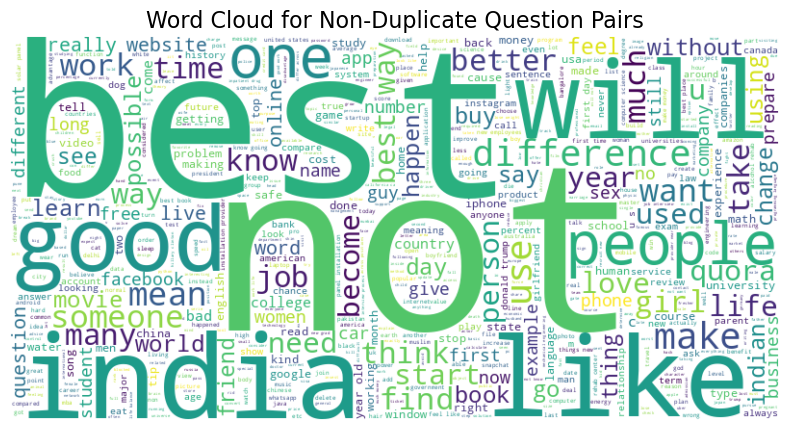

In [53]:

# Create the WordCloud object
wc = WordCloud(
    background_color="white",
    max_words=len(textn_w),
    stopwords=stopwords,
    width=800,
    height=400,
    colormap="viridis",  # Choose a colormap that you prefer
    contour_width=1,
    contour_color="steelblue",
)

# Generate the Word Cloud
wc.generate(textn_w)

# Create a figure and axis
plt.figure(figsize=(10, 5))

# Display the Word Cloud with a nicer font and colors
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for Non-Duplicate Question Pairs", fontsize=16)
plt.axis("off")

# Add a subtle gray border around the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, you can save the plot to a file
# plt.savefig("word_cloud.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


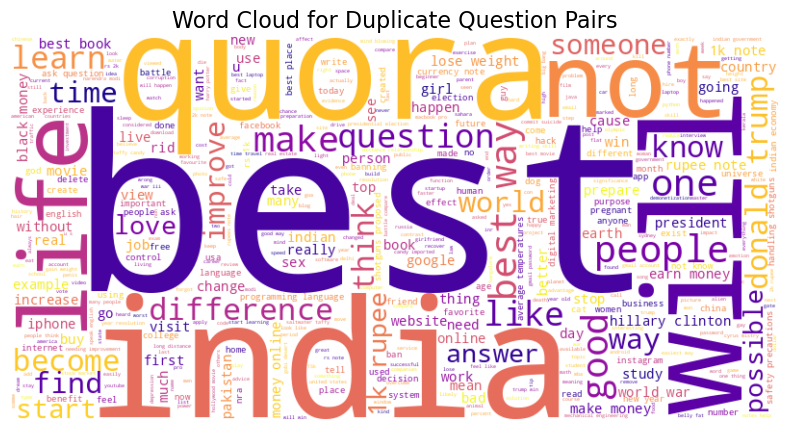

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the WordCloud object
wc = WordCloud(
    background_color="white",
    max_words=len(textp_w),
    stopwords=stopwords,
    width=800,
    height=400,
    colormap="plasma",  # Choose a colormap that you prefer
    contour_width=1,
    contour_color="darkorange",
)

# Generate the Word Cloud
wc.generate(textp_w)

# Create a figure and axis
plt.figure(figsize=(10, 5))

# Display the Word Cloud with a nicer font and colors
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for Duplicate Question Pairs", fontsize=16)
plt.axis("off")

# Add a subtle gray border around the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#  you can save the plot to a file
# plt.savefig("word_cloud_duplicate.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


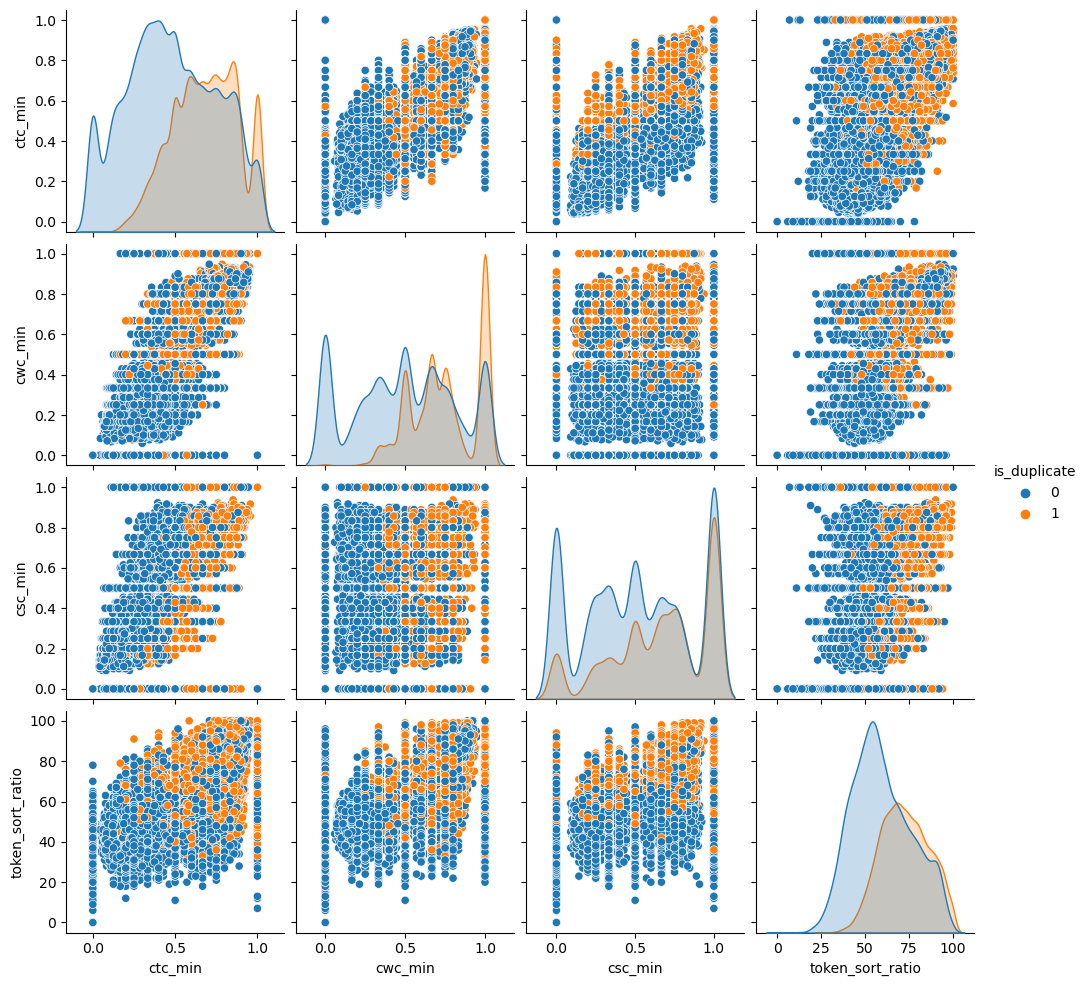

In [55]:
# Pair plot for advanced features
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

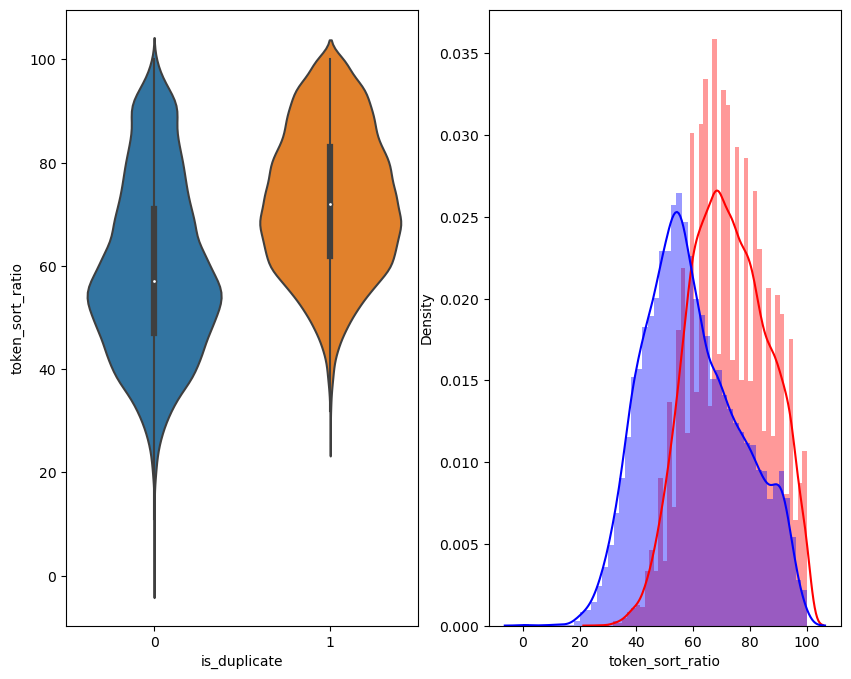

In [56]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

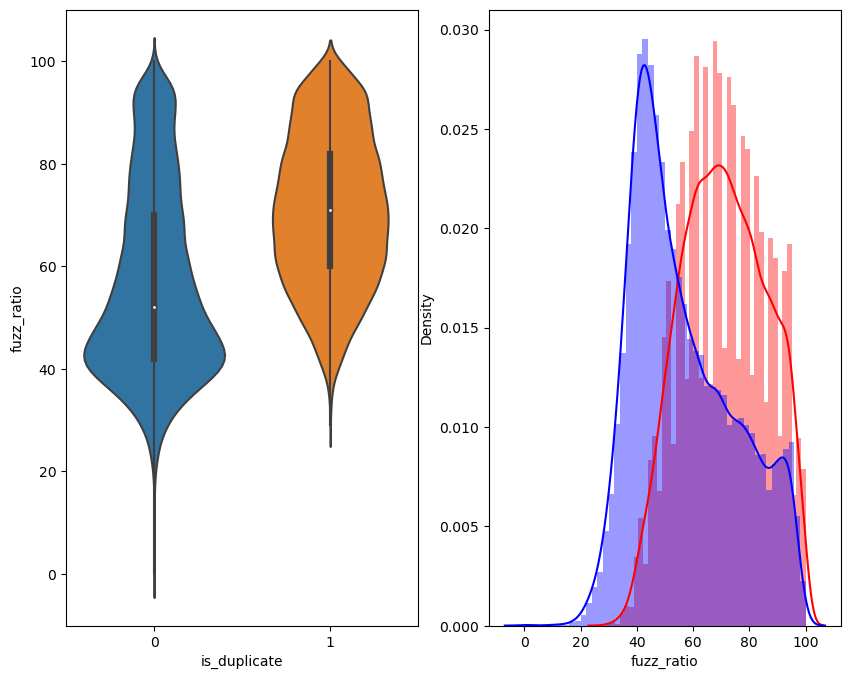

In [57]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [58]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [59]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.031s...
[t-SNE] Computed neighbors for 5000 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.127011
[t-SNE] Computed conditional probabilities in 0.293s
[t-SNE] Iteration 50: error = 86.3868408, gradient norm = 0.0888742 (50 iterations in 1.766s)
[t-SNE] Iteration 100: error = 71.0418015, gradient norm = 0.0146594 (50 iterations in 1.712s)
[t-SNE] Iteration 150: error = 68.8884201, gradient norm = 0.0081135 (50 iterations in 1.753s)
[t-SNE] Iteration 200: error = 68.0049744, gradient norm = 0.0054061 (50 iterations in 1.597s)
[t-SNE] Iteration 250: error = 67.5074615, gradient norm = 0.0042793

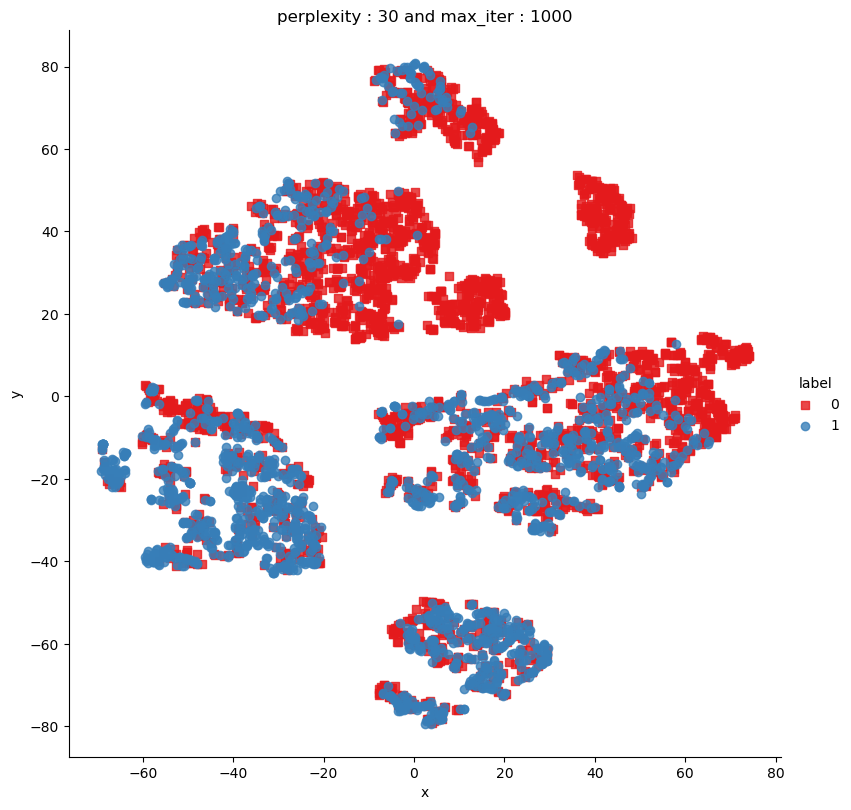

In [60]:
df_tsne = pd.DataFrame({'x': tsne2d[:, 0], 'y': tsne2d[:, 1], 'label': y})

# Draw the plot in an appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False, height=8, palette="Set1", markers=['s', 'o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()


In [61]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.030s...
[t-SNE] Computed neighbors for 5000 samples in 0.478s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.127011
[t-SNE] Computed conditional probabilities in 0.286s
[t-SNE] Iteration 50: error = 87.2877655, gradient norm = 0.0685260 (50 iterations in 5.590s)
[t-SNE] Iteration 100: error = 69.7716675, gradient norm = 0.0077412 (50 iterations in 3.478s)
[t-SNE] Iteration 150: error = 68.1048737, gradient norm = 0.0041287 (50 iterations in 3.065s)
[t-SNE] Iteration 200: error = 67.4545135, gradient norm = 0.0026254 (50 iterations in 3.415s)
[t-SNE] Iteration 250: error = 67.1019897, gradient norm = 0.0020111

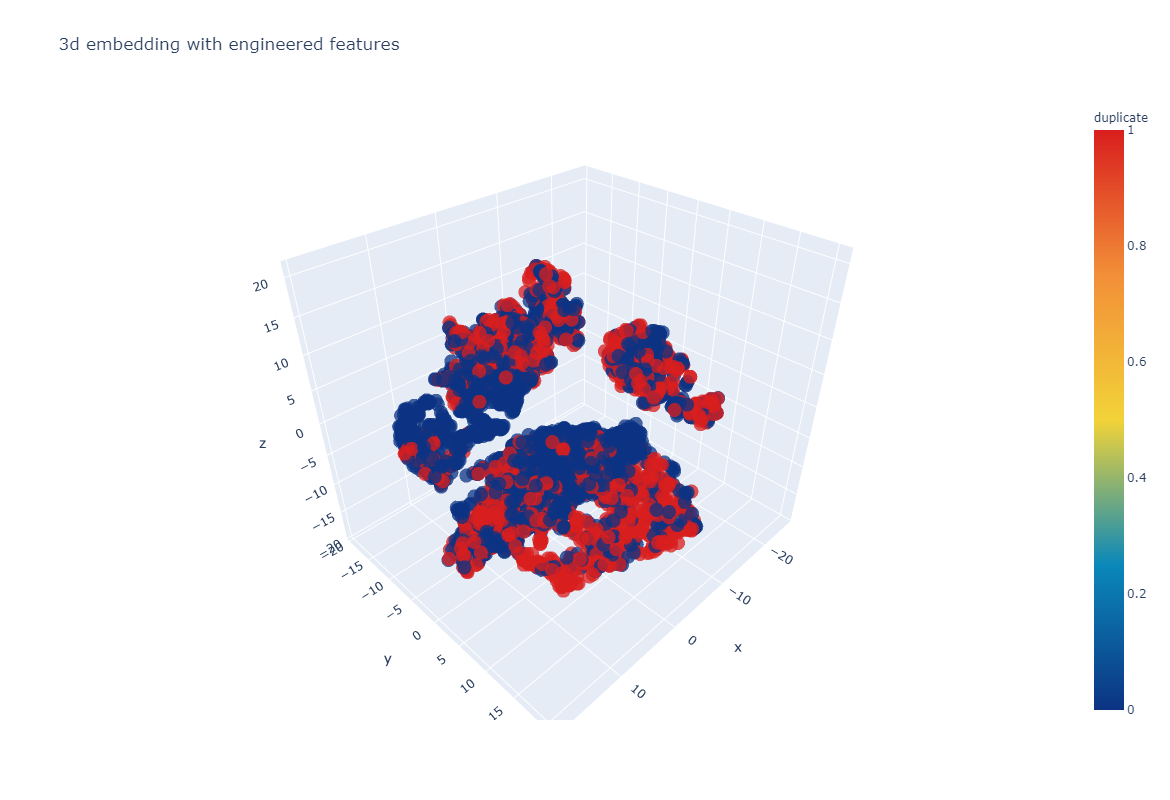

In [62]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Merge texts
questions = list(df['question1']) + list(df['question2'])

# Create and fit TF-IDF vectorizer
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# Get feature names and corresponding IDF scores
feature_names = tfidf.get_feature_names_out()
idf_scores = tfidf.idf_

# Create a dictionary mapping words to TF-IDF scores
word2tfidf = dict(zip(feature_names, idf_scores))


In [64]:
import spacy
from tqdm import tqdm

nlp = spacy.load('en_core_web_lg')

# Assuming df contains your data with 'question2' column
tokenized_texts = []

for qu1 in tqdm(list(df['question1']), desc='Tokenizing'):
    doc1 = nlp(qu1)
    tokens = [token.text for token in doc1]  # Extracting token texts
    tokenized_texts.append(tokens)

# Save the tokenized_texts to a file (one question per line)
with open('tokenized_questions.txt', 'w') as f:
    for tokens in tokenized_texts:
        f.write(' '.join(tokens) + '\n')


Tokenizing: 100%|██████████| 50000/50000 [09:14<00:00, 90.11it/s] 


In [65]:
# Load the tokenized_texts from the file
tokenized_texts = []
with open('tokenized_questions.txt', 'r') as f:
    for line in f:
        tokens = line.strip().split()
        tokenized_texts.append(tokens)

vecs1 = []

for tokens in tqdm(tokenized_texts, desc='Calculating Vectors'):
    mean_vec1 = np.zeros([len(tokens), nlp.vocab.vectors_length])
    for token in tokens:
        vec1 = nlp(token).vector
        try:
            idf = word2tfidf[token]
        except KeyError:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

df['q1_feats_m'] = list(vecs1)


Calculating Vectors: 100%|██████████| 50000/50000 [1:14:57<00:00, 11.12it/s]


In [66]:
df['q1_feats_m']

8067      [16.143067359924316, 114.9729552268982, -107.7...
368101    [-160.22526383399963, -126.24256205558777, -17...
70497     [-98.76582312583923, 16.412564873695374, -240....
226567    [-0.6196160316467285, 61.08421266078949, -20.2...
73186     [44.47576570510864, 90.05084085464478, -105.13...
                                ...                        
16314     [-162.82552129030228, 315.31973449513316, -439...
258955    [-22.82403016090393, 70.12563848495483, -148.0...
174632    [-105.65819311141968, -48.75617969036102, -79....
337708    [-33.46275472640991, 23.4189133644104, -69.450...
57909     [-129.6637282371521, 205.35354620218277, -171....
Name: q1_feats_m, Length: 50000, dtype: object

In [67]:
nlp = spacy.load('en_core_web_lg')

# Assuming df contains your data with 'question2' column
tokenized_texts = []

for qu2 in tqdm(list(df['question2']), desc='Tokenizing'):
    doc2 = nlp(qu2)
    tokens = [token.text for token in doc2]  # Extracting token texts
    tokenized_texts.append(tokens)

# Save the tokenized_texts to a file (one question per line)
with open('tokenized_questions_2.txt', 'w') as f:
    for tokens in tokenized_texts:
        f.write(' '.join(tokens) + '\n')


Tokenizing: 100%|██████████| 50000/50000 [09:11<00:00, 90.72it/s] 


In [68]:
import numpy as np
from tqdm import tqdm

# Load the tokenized_texts from the file
tokenized_texts = []
with open('tokenized_questions_2.txt', 'r') as f:
    for line in f:
        tokens = line.strip().split()
        tokenized_texts.append(tokens)

vecs2 = []

for tokens in tqdm(tokenized_texts, desc='Calculating Vectors'):
    mean_vec2 = np.zeros([len(tokens), nlp.vocab.vectors_length])
    for token in tokens:
        vec2 = nlp(token).vector
        try:
            idf = word2tfidf[token]
        except KeyError:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

df['q2_feats_m'] = list(vecs2)


Calculating Vectors: 100%|██████████| 50000/50000 [1:15:54<00:00, 10.98it/s]


In [69]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,1,1,34,34,...,1.0,0.0,8.0,90,81,88,88,0.800000,"[16.143067359924316, 114.9729552268982, -107.7...","[-7.836297988891602, 102.64693021774292, -107...."
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,1,1,53,51,...,1.0,2.0,10.0,73,73,73,73,0.326923,"[-160.22526383399963, -126.24256205558777, -17...","[-52.914753794670105, -16.92444086074829, -173..."
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,1,1,96,45,...,0.0,8.0,12.0,41,39,39,44,0.108696,"[-98.76582312583923, 16.412564873695374, -240....","[-3.296947717666626, 25.835172414779663, -14.2..."
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,2,2,44,52,...,1.0,2.0,8.0,96,89,72,68,0.288889,"[-0.6196160316467285, 61.08421266078949, -20.2...","[25.980807781219482, 55.81324517726898, -83.53..."
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,1,4,38,29,...,1.0,2.0,8.0,81,71,68,62,0.366667,"[44.47576570510864, 90.05084085464478, -105.13...","[48.00270962715149, 35.39637041091919, -29.822..."


In [70]:
df_copy=df.copy()

In [72]:
df_q1 = pd.DataFrame(df_copy.q1_feats_m.values.tolist(), index= df_copy.index)
df_q2 = pd.DataFrame(df_copy.q2_feats_m.values.tolist(), index= df_copy.index)
df_q1=df_q1.reset_index().rename(columns={'index': 'id'})
df_q2=df_q2.reset_index().rename(columns={'index': 'id'})


In [73]:
df_q1.head()

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,8067,16.143067,114.972955,-107.724227,-41.958848,-11.968284,118.077927,-36.849088,93.575367,-79.421827,...,64.052356,-7.667799,-8.225841,31.422704,-31.282718,-58.484162,32.328661,75.328290,-34.442979,-24.339824
1,368101,-160.225264,-126.242562,-178.722333,17.173494,201.201865,-56.259599,-80.920271,232.265511,-149.659266,...,96.821623,-117.113701,102.667344,-122.088680,-64.620536,-1.753287,11.830905,-85.592725,-162.915200,63.580008
2,70497,-98.765823,16.412565,-240.152965,79.606326,280.823550,17.693061,53.227621,362.044989,-120.235621,...,5.215610,-157.577407,168.465622,-42.244236,-167.686911,-65.621276,-0.784536,-26.123186,-201.753369,57.213172
3,226567,-0.619616,61.084213,-20.216214,-45.654762,28.633077,39.435872,42.828773,162.497645,-159.854139,...,10.860137,-29.970116,15.308453,-52.467855,9.944227,-64.312316,-6.848677,-16.303620,-94.428952,142.004334
4,73186,44.475766,90.050841,-105.139565,-26.720787,65.876077,101.351733,78.274999,60.084399,-86.608429,...,199.729542,-37.572490,53.514107,73.514462,-62.509630,-37.882511,-11.777449,11.257261,-102.988686,126.212254


In [74]:
df_q2.head()

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,8067,-7.836298,102.646930,-107.420031,-45.362023,-11.371086,103.762792,-38.133027,78.144933,-85.954347,...,77.862360,8.613531,7.997421,34.187974,-51.199043,-69.351400,19.260541,78.932982,-28.718391,-32.176169
1,368101,-52.914754,-16.924441,-173.559141,16.184572,113.369637,-3.958979,-18.057674,201.217817,-139.691183,...,72.244117,-143.217271,119.273339,-139.492690,-36.729954,-23.838304,-28.073391,-24.664757,-196.343921,63.430181
2,70497,-3.296948,25.835172,-14.224781,-9.005408,83.116934,9.889249,6.791765,115.303230,-74.339015,...,10.094394,-4.276049,19.246828,79.830730,-29.084617,50.302225,-14.456909,-62.136050,-54.037833,58.361832
3,226567,25.980808,55.813245,-83.537899,-68.334517,79.343287,18.972927,12.546966,206.030957,-162.930061,...,-38.812486,-64.756312,5.521178,-82.614321,22.667091,-68.710343,-58.475842,-67.330983,-205.167868,123.048073
4,73186,48.002710,35.396370,-29.822131,-73.463180,127.828885,29.533877,118.014406,94.505302,-4.397532,...,103.620102,-14.966130,59.217239,67.267384,-17.734783,-40.562708,14.776074,-19.699716,-62.339846,27.864048


In [75]:
df_copy = pd.merge(df_copy, df_q1, on='id', how='left')
df_copy = pd.merge(df_copy, df_q2, on='id', how='left')

In [76]:
df_copy.drop(['q1_feats_m', 'q2_feats_m'], axis=1, inplace=True)

In [77]:
df_copy.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,1,1,34,34,...,77.862360,8.613531,7.997421,34.187974,-51.199043,-69.351400,19.260541,78.932982,-28.718391,-32.176169
1,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,1,1,53,51,...,72.244117,-143.217271,119.273339,-139.492690,-36.729954,-23.838304,-28.073391,-24.664757,-196.343921,63.430181
2,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,1,1,96,45,...,10.094394,-4.276049,19.246828,79.830730,-29.084617,50.302225,-14.456909,-62.136050,-54.037833,58.361832
3,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,2,2,44,52,...,-38.812486,-64.756312,5.521178,-82.614321,22.667091,-68.710343,-58.475842,-67.330983,-205.167868,123.048073
4,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,1,4,38,29,...,103.620102,-14.966130,59.217239,67.267384,-17.734783,-40.562708,14.776074,-19.699716,-62.339846,27.864048


In [78]:
df_copy.to_csv('final_df.csv', index=False)

In [101]:
df_copy=df_copy.fillna(0)

In [103]:
y = df_copy['is_duplicate']
x = df_copy.drop(['id','qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [96]:
x.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,34,34,8,8,7.0,16.0,0.437500,2,...,77.862360,8.613531,7.997421,34.187974,-51.199043,-69.351400,19.260541,78.932982,-28.718391,-32.176169
1,1,1,53,51,11,9,6.0,20.0,0.300000,2,...,72.244117,-143.217271,119.273339,-139.492690,-36.729954,-23.838304,-28.073391,-24.664757,-196.343921,63.430181
2,1,1,96,45,16,8,2.0,24.0,0.083333,2,...,10.094394,-4.276049,19.246828,79.830730,-29.084617,50.302225,-14.456909,-62.136050,-54.037833,58.361832
3,2,2,44,52,7,9,4.0,16.0,0.250000,4,...,-38.812486,-64.756312,5.521178,-82.614321,22.667091,-68.710343,-58.475842,-67.330983,-205.167868,123.048073
4,1,4,38,29,9,7,3.0,16.0,0.187500,5,...,103.620102,-14.966130,59.217239,67.267384,-17.734783,-40.562708,14.776074,-19.699716,-62.339846,27.864048


In [104]:
#Train test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [97]:
print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (40000, 626)
Number of data points in test data : (10000, 626)


In [109]:
import numpy as np
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_random_classification(test_labels, num_classes=2):
    test_len = len(test_labels)
    
    # Generate random probabilities and normalize
    rand_probs = np.random.rand(test_len, num_classes)
    predicted_probs = rand_probs / rand_probs.sum(axis=1, keepdims=True)
    
    # Calculate log loss
    logloss = log_loss(test_labels, predicted_probs, eps=1e-15)
    print("Log Loss on Test Data using Random Model:", logloss)
    
    # Convert probabilities to predicted classes
    predicted_classes = np.argmax(predicted_probs, axis=1)
    
    # Calculate confusion matrix, recall, and precision
    cm = confusion_matrix(test_labels, predicted_classes)
    recall = recall_score(test_labels, predicted_classes)
    precision = precision_score(test_labels, predicted_classes)
    
    # Create a single 1x3 grid for the subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[0])
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')
    axs[0].set_title('Confusion Matrix')
    
    # Plot recall matrix
    sns.heatmap([[recall, 1 - recall], [0, 0]], annot=True, fmt='.2f', cmap='Greens', cbar=False,
                xticklabels=['Recall'], yticklabels=['Class 0', 'Class 1'], ax=axs[1])
    axs[1].set_title('Recall Matrix')
    
    # Plot precision matrix
    sns.heatmap([[precision, 0], [1 - precision, 0]], annot=True, fmt='.2f', cmap='Oranges', cbar=False,
                xticklabels=['Precision'], yticklabels=['Class 0', 'Class 1'], ax=axs[2])
    axs[2].set_title('Precision Matrix')
    
    plt.tight_layout()
    plt.show()




Log Loss on Test Data using Random Model: 0.8733646683037122


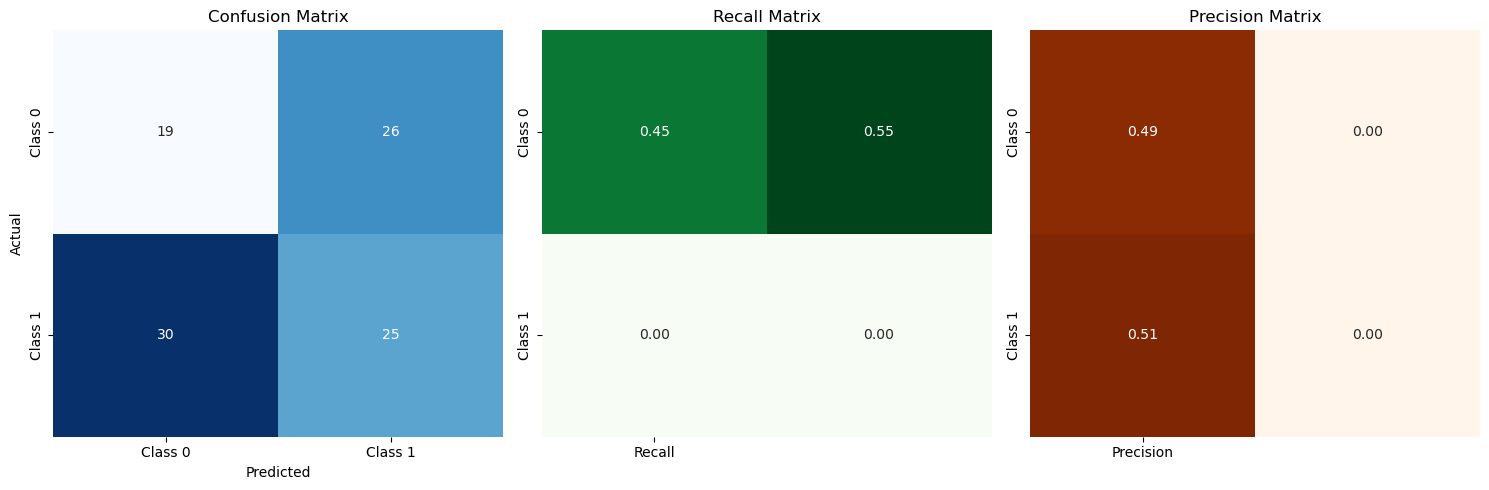

In [110]:
# Example usage
evaluate_random_classification(np.random.randint(2, size=100), num_classes=2)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score
import seaborn as sns

def evaluate_logistic_regression(x_train, y_train, x_test, y_test):
    # Fit a logistic regression classifier
    model = LogisticRegression()
    model.fit(x_train, y_train)

    # Predict probabilities for the test set
    y_pred_prob = model.predict_proba(x_test)

    # Calculate log loss
    logloss = log_loss(y_test, y_pred_prob)

    # Predict labels for the test set
    y_pred = model.predict(x_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate precision and recall
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Calculate and plot precision matrix
    precision_matrix = np.array([[precision, 1 - precision], [0, 0]])
    plt.subplot(1, 3, 2)
    sns.heatmap(precision_matrix, annot=True, fmt=".2f", cmap="Oranges", cbar=False,
                xticklabels=['Precision'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Precision Matrix')

    # Calculate and plot recall matrix
    recall_matrix = np.array([[recall, 0], [1 - recall, 0]])
    plt.subplot(1, 3, 3)
    sns.heatmap(recall_matrix, annot=True, fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=['Recall'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Recall Matrix')

    plt.tight_layout()
    plt.show()

    print(f'Log Loss: {logloss:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')




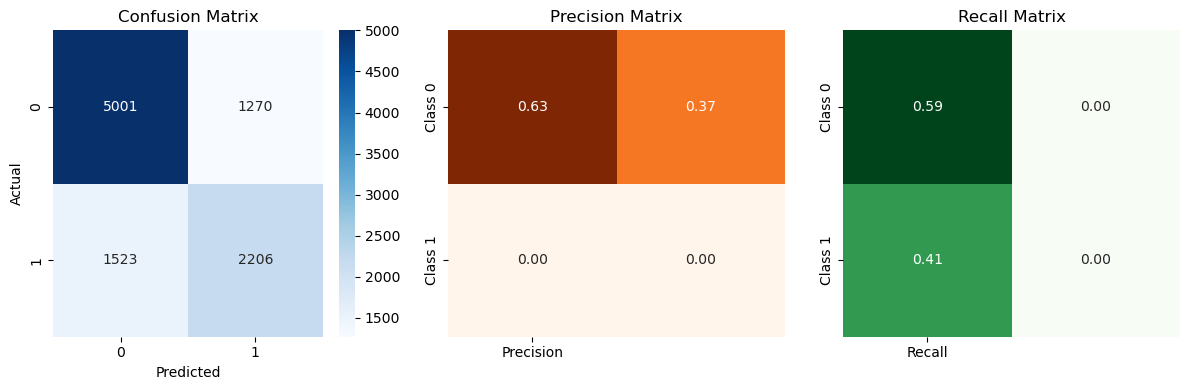

Log Loss: 0.5437
Precision: 0.6346
Recall: 0.5916


In [114]:
# usage
# Assuming x_train, y_train, x_test, y_test are your training and testing data
evaluate_logistic_regression(x_train, y_train, x_test, y_test)

In [119]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import log_loss, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score

def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test, num_rounds=400, early_stopping_rounds=20, verbose=True):
    """
    Train an XGBoost model for binary classification, evaluate using log loss,
    and plot confusion matrix, precision-recall curve, ROC curve, and AUC.

    Parameters:
        X_train (array-like): Training feature matrix.
        y_train (array-like): Training labels.
        X_test (array-like): Test feature matrix.
        y_test (array-like): Test labels.
        num_rounds (int, optional): Maximum number of boosting rounds. Default is 400.
        early_stopping_rounds (int, optional): Number of rounds to wait for no improvement before stopping. Default is 20.
        verbose (bool, optional): Whether to print verbose output during training. Default is True.

    Returns:
        float: Log loss on the test data.
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.02,
        'max_depth': 4
    }

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]

    bst = xgb.train(params, d_train, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose)

    predictions = bst.predict(d_test)
    logloss = log_loss(y_test, predictions, labels=[0, 1], eps=1e-15)

    if verbose:
        print("Log Loss on Test Data:", logloss)

    # Calculate confusion matrix
    y_pred = (predictions > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    
    # Create a 2x2 grid for the subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0, 0])
    axs[0, 0].set_title('Confusion Matrix')
    axs[0, 0].set_xlabel('Predicted')
    axs[0, 0].set_ylabel('Actual')
    
    # Plot ROC curve
    axs[1, 0].plot(fpr, tpr, color='b', linewidth=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    axs[1, 0].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1, 0].set_xlabel('False Positive Rate')
    axs[1, 0].set_ylabel('True Positive Rate')
    axs[1, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[1, 0].legend(loc='lower right')
    axs[1, 0].set_xlim([0.0, 1.0])
    axs[1, 0].set_ylim([0.0, 1.05])
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    
    # Plot precision-recall curve
    axs[1, 1].plot(recall, precision, color='b', linewidth=2)
    axs[1, 1].set_xlabel('Recall')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].set_title('Precision-Recall Curve')
    axs[1, 1].set_xlim([0.0, 1.0])
    axs[1, 1].set_ylim([0.0, 1.05])
    
    # Calculate recall matrix
    recall_matrix = np.array([[recall[1], 1 - recall[1]], [0, 0]])
    
    # Plot recall matrix
    sns.heatmap(recall_matrix, annot=True, fmt='.2f', cmap='Greens', cbar=False,
                xticklabels=['Recall'], yticklabels=['Class 0', 'Class 1'], ax=axs[0, 1])
    axs[0, 1].set_title('Recall Matrix')
    
    plt.tight_layout()
    plt.show()

    return logloss



[0]	train-logloss:0.68598	valid-logloss:0.68590
[1]	train-logloss:0.67909	valid-logloss:0.67890
[2]	train-logloss:0.67247	valid-logloss:0.67221
[3]	train-logloss:0.66610	valid-logloss:0.66572
[4]	train-logloss:0.66007	valid-logloss:0.65959
[5]	train-logloss:0.65408	valid-logloss:0.65354
[6]	train-logloss:0.64836	valid-logloss:0.64773
[7]	train-logloss:0.64277	valid-logloss:0.64212
[8]	train-logloss:0.63743	valid-logloss:0.63669
[9]	train-logloss:0.63223	valid-logloss:0.63145
[10]	train-logloss:0.62719	valid-logloss:0.62638
[11]	train-logloss:0.62233	valid-logloss:0.62146
[12]	train-logloss:0.61766	valid-logloss:0.61676
[13]	train-logloss:0.61311	valid-logloss:0.61217
[14]	train-logloss:0.60856	valid-logloss:0.60765
[15]	train-logloss:0.60430	valid-logloss:0.60333
[16]	train-logloss:0.60024	valid-logloss:0.59926
[17]	train-logloss:0.59620	valid-logloss:0.59520
[18]	train-logloss:0.59219	valid-logloss:0.59120
[19]	train-logloss:0.58840	valid-logloss:0.58739
[20]	train-logloss:0.58479	val

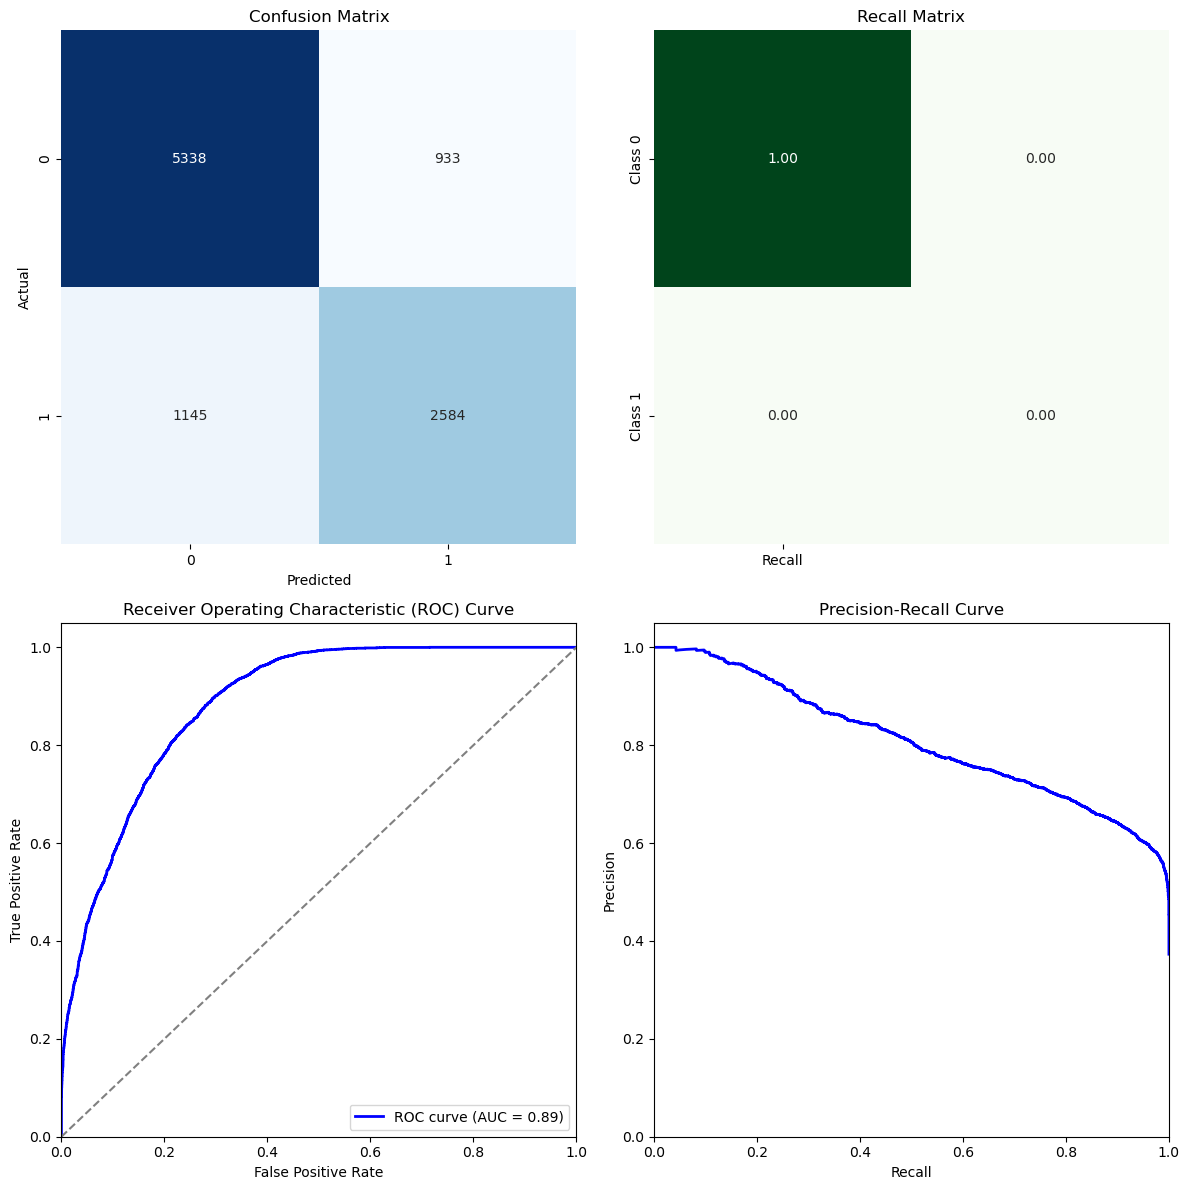

0.3997244414963725

In [120]:
# Usage 
train_and_evaluate_xgboost(x_train, y_train, x_test, y_test)


#### Conclusion
The solution process began with loading and cleaning the dataset, followed by exploratory data analysis (EDA) and feature engineering. Subsequently, the direction of the analysis shifted towards training predictive machine learning models. Initially, the dataset consisted of six columns. However, after feature engineering and the conversion of text to word2vec representations, the dataset expanded to over 600 columns.

For predictive modeling, both Logistic Regression and XGBoost models were employed. To establish a baseline for comparison, a random baseline model was also established. Upon evaluation, the XGBoost model exhibited superior performance compared to the Logistic Regression classifier. Additionally, both models outperformed the random baseline model by a significant margin.

Further enhancements in performance could be achieved through hyperparameter tuning and the utilization of deep learning techniques. These refinements are anticipated to be incorporated in future iterations of this work, with the aim of achieving even more accurate and effective predictions.

# References

1. [FuzzyWuzzy: Fuzzy String Matching in Python](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
2. [When to Use Which Fuzz Function to Compare 2 Strings](https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings)
3. [NLTK Library](https://www.nltk.org/)
4. [spaCy Natural Language Processing Library](https://spacy.io/)
5. [en_core_web_lg: spaCy's Large English Language Model](https://spacy.io/models/en#en_core_web_lg)
6. [Beautiful Soup: HTML Parsing Library](https://www.crummy.com/software/BeautifulSoup/)
7. [pandas: Data Analysis and Manipulation Library](https://pandas.pydata.org/)
8. [numpy: Numerical Computing Library](https://numpy.org/)
9. [seaborn: Data Visualization Library](https://seaborn.pydata.org/)
10. [t-SNE (t-distributed Stochastic Neighbor Embedding)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)
